# Data Inspection


In [0]:
from os import listdir
from google.colab import drive
import os
import gc

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras.utils import model_to_dot, plot_model

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

In [0]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Change this to the path where this folder is located in your Drive
os.chdir('/content/drive/My Drive/')

In [0]:
i1 = np.load('data/train_images/sample-49.npy')
i1.shape

(15, 256, 256)

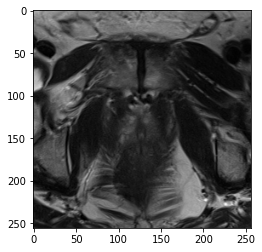

In [0]:
plt.imshow(i1[2], cmap='gray')

In [0]:
s1 = np.load('data/train_labels/sample-0.npy')
s1.shape

(16, 256, 256)

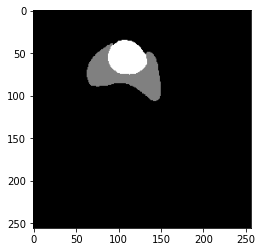

In [0]:
plt.imshow(s1[2], cmap='gray')

In [0]:
def get_network(input_shape=(256,256)):
    # layer notation: X_Y where X represents the "block" in which the layer is, and Y the position in the block 
    inputs = Input(shape=(input_shape[0], input_shape[1], 1)) # not sure why (256, 256, 1) as (256, 256,) didn't work...
    
    # padding=same, because our mask is the same size as the input. This is different than in the paper. Therefore, we don't crop
    
    # block 1
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='conv1_1')(inputs) # according to paper: unpadded 2D convs. Valid drops data if dimensions don't match
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='conv1_2')(conv1_1)

    # block 2, going down. Filter size doubles
    pool2_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv1_2) # no activation function?
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='conv2_2')(pool2_1)
    conv2_3 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='conv2_3')(conv2_2)
    
    # block 3, going down. Filter size doubles
    pool3_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv2_3) # no activation function?
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv3_2')(pool3_1)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv3_3')(conv3_2)
    
    # block 4, going down. Filter size doubles
    pool4_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv3_3) # no activation function?
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv4_2')(pool4_1)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv4_3')(conv4_2)
    
    # block 5, going down. Filter size doubles
    pool5_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv4_3) # no activation function?
    conv5_2 = Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu', name='conv5_2')(pool5_1)
    conv5_3 = Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu', name='conv5_3')(conv5_2) # this leaves us with 10x10x1024 vs 28x28x1024 as in the paper. Maybe one step too deep for our input size
    
    # block 6, going up. 2x2 up convolution + concatenation from block 4
    # here: stride refers to the output and not the input
    up6_1 = Conv2DTranspose(filters=512, kernel_size=(1,1), strides=(2,2), padding='same')(conv5_3) # not sure if up-sampling or deconvolution. Video https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ says learned feature map. Therefore, a proper deconvolution makes more sense, as up-sampling is also sparse
    concat6_3 = Concatenate()([conv4_3, up6_1])
    conv6_4 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv6_2')(concat6_3)
    conv6_5 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='conv6_3')(conv6_4)

    # block 7, going up. 2x2 up convolution + concatenation from block 3
    up7_1 = Conv2DTranspose(filters=256, kernel_size=(1,1), strides=(2,2), padding='same')(conv6_5) 
    concat7_3 = Concatenate()([conv3_3, up7_1])
    conv7_4 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv7_2')(concat7_3)
    conv7_5 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv7_3')(conv7_4)

    # block 8, going up. 2x2 up convolution + concatenation from block 2
    up8_1 = Conv2DTranspose(filters=128, kernel_size=(1,1), strides=(2,2), padding='same')(conv7_5) 
    concat8_3 = Concatenate()([conv2_3, up8_1])
    conv8_4 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv8_2')(concat8_3)
    conv8_5 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv8_3')(conv8_4)

    
    # block 9, going up. 2x2 up convolution + concatenation from block 2 + 1x1 conv. Final block
    up9_1 = Conv2DTranspose(filters=128, kernel_size=(1,1), strides=(2,2), padding='same')(conv8_5) 
    concat9_2 = Concatenate()([conv1_2, up9_1])
    conv9_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv9_3')(concat9_2)
    conv9_4 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv9_4')(conv9_3)
    out_layer = Conv2D(filters=3, kernel_size=(1,1), padding='same', name='out_layer', activation='softmax')(conv9_4)
    
    
    model = Model(inputs=inputs, outputs=out_layer)
    # random choice of adam and binary cross entropy loss. Metric is also wrong, need to implement IoU metric
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

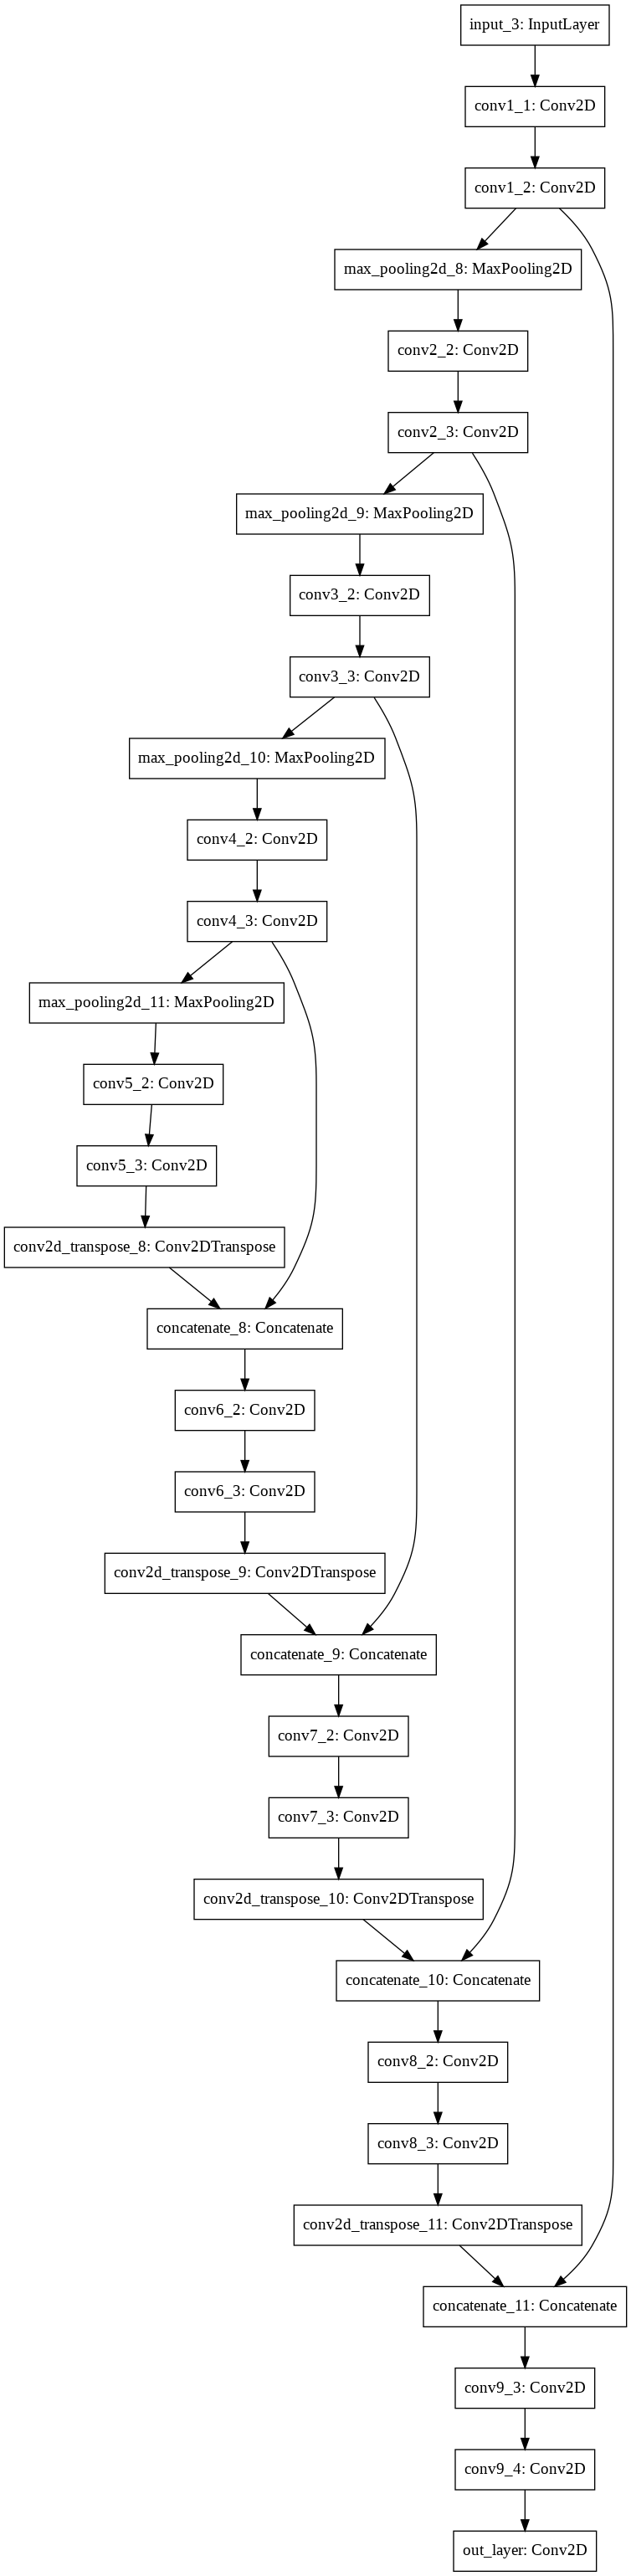

In [0]:
model = get_network()
model.summary()
plot_model(model)

In [0]:
"""
The original y is an x,y grayscale (0-255) image with 3 colors: 0, 1 and 2. Background, gland, peripheral zone.
We however have 3 different outputs, therefore we split the image into 3 images (one hot encoding) that each have 0/1
if we see the respective class.
"""
def get_y(y_in):
    num_images = y_in.shape[0]
    y = np.zeros((num_images,256,256,3))
    i = 0
    for img in y_in:

        tmp = np.copy(img)
        # layer of background pixels
        tmp[tmp==0] = 3
        tmp[tmp<3] = 0 
        tmp[tmp==3] = 1 
        y[i,:,:,0] = np.reshape(tmp, (256,256))
        #if(i == 2):
        #    fig = plt.figure()
        #    fig.add_subplot(1, 2, 1)
        #    plt.imshow(img, cmap='gray')
        #    fig.add_subplot(1, 2, 2)
        #    plt.imshow(y[i,:,:,0], cmap='gray')

        # layer of peripheral pixels
        tmp = np.copy(img)
        tmp[tmp != 1] = 0
        y[i,:,:,1] = np.reshape(tmp, (256,256))
        #if(i == 2):
        #    fig = plt.figure()
        #    fig.add_subplot(1, 2, 1)
        #    plt.imshow(img, cmap='gray')
        #    fig.add_subplot(1, 2, 2)
        #    plt.imshow(y[i,:,:,1], cmap='gray')

        # layer of gland pixels
        tmp = np.copy(img)
        tmp[tmp != 2] = 0
        tmp[tmp == 2] = 1
        y[i,:,:,2] = np.reshape(tmp, (256,256))
        #if(i == 2):
        #    fig = plt.figure()
        #    fig.add_subplot(1, 2, 1)
        #    plt.imshow(img, cmap='gray')
        #    fig.add_subplot(1, 2, 2)
        #    plt.imshow(y[i,:,:,2], cmap='gray')

        i += 1
    return y

In [0]:
files = listdir('data/train_images')
xs = []
ys =[]
i = 0
"""
Load, convert and concatenate the data. We might split the train data to train/test because there are no labels for the test images
"""
for file in files:
    x = np.load('data/train_images/'+file)
    y_loaded = np.load('data/train_labels/'+file)
    y = get_y(y_loaded)
    
    xs.append(x)
    ys.append(y)

X_train = np.concatenate(xs)
Y_train = np.concatenate(ys)

# Data augmentation

Rotate, shift height and width and zoom

In [0]:
def get_data_generator(X_train, Y_train):
  seed = 0xDEADBEEF

  data_gen_args = dict(rotation_range=10,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=0.01,
                    height_shift_range=0.01,
                    zoom_range=0.1)
  image_datagen = ImageDataGenerator(**data_gen_args)
  mask_datagen = ImageDataGenerator(**data_gen_args)
  
  X_train = X_train.reshape((X_train.shape[0], 256, 256, 1))
  X_train = X_train.astype('float32')

  Y_train = Y_train.reshape((Y_train.shape[0], 256, 256, 3))
  Y_train = Y_train.astype('float32')
  
  image_datagen.fit(X_train)
  mask_datagen.fit(Y_train)

  train_x_generator = image_datagen.flow(X_train, seed=seed, batch_size=15)
  train_y_generator = mask_datagen.flow(Y_train, seed=seed, batch_size=15)

  train_generator = zip(train_x_generator, train_y_generator)
  return train_generator

Cross validation

In [0]:
def cross_validation(model, X, Y, folds=3, shuffle=True, verbose=0):
    kf = KFold(n_splits=folds)
    i = 0
    for train_index, test_index in kf.split(X):
        print("Iteration", int(i+1))
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        train_generator = get_data_generator(X_train, Y_train)
        model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(X_train) / 15, epochs=35)
        model.evaluate(X_test, Y_test)
        i += 1

In [0]:
cross_validation(model, X_train, Y_train)

Iteration 1
Epoch 1/35
38/37 [==============================] - 161s 4s/step - loss: 0.1075 - accuracy: 0.9319
Epoch 2/35
38/37 [==============================] - 147s 4s/step - loss: 0.1026 - accuracy: 0.9337
Epoch 3/35
38/37 [==============================] - 147s 4s/step - loss: 0.0999 - accuracy: 0.9350
Epoch 4/35
38/37 [==============================] - 147s 4s/step - loss: 0.1071 - accuracy: 0.9316
Epoch 5/35
38/37 [==============================] - 147s 4s/step - loss: 0.0973 - accuracy: 0.9386
Epoch 6/35
38/37 [==============================] - 147s 4s/step - loss: 0.0883 - accuracy: 0.9448
Epoch 7/35
38/37 [==============================] - 147s 4s/step - loss: 0.0828 - accuracy: 0.9495
Epoch 8/35
38/37 [==============================] - 147s 4s/step - loss: 0.0818 - accuracy: 0.9494
Epoch 9/35
38/37 [==============================] - 148s 4s/step - loss: 0.0710 - accuracy: 0.9543
Epoch 10/35
38/37 [==============================] - 147s 4s/step - loss: 0.0695 - accuracy: 0.95

Visualize a batch of the data augmentation and save to directory

In [0]:
 data_gen_args = dict(rotation_range=10,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=0.01,
                    height_shift_range=0.01,
                    zoom_range=0.1)
image_datagen = ImageDataGenerator(**data_gen_args)

In [0]:
 image_datagen = ImageDataGenerator(**data_gen_args)

In [0]:
X_train = X_train.reshape((X_train.shape[0], 256, 256, 1))
X_train = X_train.astype('float32')
image_datagen.fit(X_train)

In [0]:
for X_batch, y_batch in image_datagen.flow(X_train, Y_train, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(256, 256), cmap=plt.get_cmap('gray'))
	plt.show()
	break

In [0]:
train_generator = get_data_generator(30, X_train, Y_train)

In [0]:
model.fit_generator(generator= train_generator,
                    steps_per_epoch=len(X_train) / 15, epochs=35)

In [0]:
model.save('model.h5')

In [68]:
model.evaluate(X_test, Y_test)

3/3 [==============================] - 3s 861ms/step - loss: 0.0982 - accuracy: 0.9509


[0.09815365821123123, 0.9508507251739502]

In [0]:
prediction = model.predict(X_test)

Visualize some of the predictions

In [0]:
pred_0 = np.copy(prediction[10])
#pred_0[pred_0 > 0.15] = 1
#pred_0[pred_0 <= 0.15] = 0

fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(pred_0[:,:,0], cmap='gray')
fig.add_subplot(2,2,2)
plt.imshow(pred_0[:,:,1], cmap='gray')
fig.add_subplot(2,2,3)
plt.imshow(pred_0[:,:,2], cmap='gray')
fig.add_subplot(2,2,4)
plt.imshow(X_test[30], cmap='gray')

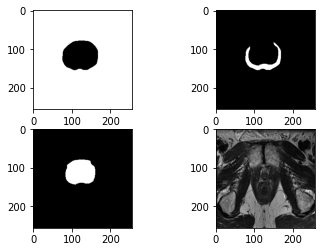

In [71]:
y_plot = Y_test[10]

fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(y_plot[:,:,0], cmap='gray')
fig.add_subplot(2,2,2)
plt.imshow(y_plot[:,:,1], cmap='gray')
fig.add_subplot(2,2,3)
plt.imshow(y_plot[:,:,2], cmap='gray')
fig.add_subplot(2,2,4)
plt.imshow(X_test[30], cmap='gray')

In [0]:
gc.collect()